# Determining xy-coordinates of pupil in image

The purpose of this study is to develop a network that can pinpoint the xy-coordinates (pixel value) of the pupil centre of an eye. The model is to be deployed using AWS and output xy-values given the image that is passed.

> **_STRETCH_**: As a stretch activity, let's also try to output the image  overlaid with a red dot that marks the xy-coorindate position of the pupil.

In [1]:
from modules import config, utils, dataset, model
from modules.model import baseline_model, final_model
from modules.dataset import get_data
from modules.config import LR, EPOCHS

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid', palette='viridis', context='talk')
%matplotlib inline

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

## Import & Resize Dataset

The dataset we will be using is the [gaze dataset](https://www.kaggle.com/datasets/4quant/eye-gaze) on Kaggle.

We have defined our target as `keypoints` and the data as `images`. The `images` dataset will be converted to a dataframe and saved, while the `keypoints` can be saved directly since it is imported as a dataframe.

To aid with data wrangling, we will downsample the images while still retaining enough fidelity to ensure accurate keypoint predictions.

In [2]:
# convert image to dataframe and save
dx_images = utils.get_images(scale=True, save=True, result='dx')
img_array = utils.get_images(scale=True, save=False, result='array')

# target dataframe and output
df_keypoints = utils.get_keypoints(with_image_locs=True, scale=True, save=True)

Getting images in <grayscale>...
Getting image locations...
Resizing images from (480, 640) to (128, 96).

Saved image dataframe to ../output/P1_imgs.parquet.

Getting images in <grayscale>...
Getting image locations...
Resizing images from (480, 640) to (128, 96).

Reading data from ../data/lpw/1/1.txt...
Reading data from ../data/lpw/1/4.txt...
Reading data from ../data/lpw/1/9.txt...
Reducing keypoint data from (5999)...
... to (500)

Getting image filenames...
... and add column of image filenames to keypoint DataFrame.
Saved keypoint dataframe to ../output/P1_kpts.parquet.



## Exploratory Data Analysis

In [3]:
# print shape
print(df_keypoints.shape)
print(dx_images.dims)
print(len(img_array))
print(len(dx_images.data_vars))

(500, 3)
Frozen({'image': 500, 'height': 96})
500
128


In [4]:
dx_images.info()

xarray.Dataset {
dimensions:
	image = 500 ;
	height = 96 ;

variables:
	int64 image(image) ;
	int64 height(height) ;
	float64 0(image, height) ;
	float64 1(image, height) ;
	float64 2(image, height) ;
	float64 3(image, height) ;
	float64 4(image, height) ;
	float64 5(image, height) ;
	float64 6(image, height) ;
	float64 7(image, height) ;
	float64 8(image, height) ;
	float64 9(image, height) ;
	float64 10(image, height) ;
	float64 11(image, height) ;
	float64 12(image, height) ;
	float64 13(image, height) ;
	float64 14(image, height) ;
	float64 15(image, height) ;
	float64 16(image, height) ;
	float64 17(image, height) ;
	float64 18(image, height) ;
	float64 19(image, height) ;
	float64 20(image, height) ;
	float64 21(image, height) ;
	float64 22(image, height) ;
	float64 23(image, height) ;
	float64 24(image, height) ;
	float64 25(image, height) ;
	float64 26(image, height) ;
	float64 27(image, height) ;
	float64 28(image, height) ;
	float64 29(image, height) ;
	float64 30(image, heig

In [5]:
img_array

[array([[156, 156, 156, ..., 133, 127, 127],
        [158, 158, 159, ..., 135, 131, 131],
        [159, 161, 159, ..., 135, 132, 134],
        ...,
        [156, 153, 154, ..., 138, 137, 137],
        [159, 157, 155, ..., 141, 140, 140],
        [159, 157, 155, ..., 146, 142, 142]], dtype=uint8),
 array([[157, 157, 157, ..., 133, 128, 128],
        [157, 157, 157, ..., 133, 128, 128],
        [158, 158, 160, ..., 133, 132, 132],
        ...,
        [155, 155, 154, ..., 140, 138, 138],
        [157, 157, 155, ..., 145, 143, 143],
        [157, 157, 155, ..., 145, 143, 143]], dtype=uint8),
 array([[157, 157, 157, ..., 134, 129, 129],
        [157, 157, 157, ..., 134, 129, 129],
        [158, 158, 160, ..., 134, 132, 132],
        ...,
        [155, 155, 153, ..., 139, 137, 137],
        [157, 157, 156, ..., 145, 142, 142],
        [157, 157, 156, ..., 145, 142, 142]], dtype=uint8),
 array([[157, 157, 157, ..., 134, 128, 128],
        [157, 157, 157, ..., 134, 128, 128],
        [161, 16

In [6]:
# import images from parquet (as DataFrame) and convert back to array
images = pd.read_parquet(f'{config.OUTPUT_PATH}/P1_imgs.parquet')
images = utils.df_to_array(images)

# import keypoints from parquet (as array)
keypoints = pd.read_parquet(f'{config.OUTPUT_PATH}/P1_kpts.parquet')

In [7]:
keypoints.head(20)

,x,y,image_name
0,66.800,61.000,thumb_01_01_0001.jpg
1,66.520,60.400,thumb_01_01_0002.jpg
2,66.040,60.080,thumb_01_01_0003.jpg
3,65.600,59.560,thumb_01_01_0004.jpg
4,65.280,58.440,thumb_01_01_0005.jpg
5,65.200,57.400,thumb_01_01_0006.jpg
6,65.600,53.480,thumb_01_01_0007.jpg
7,65.600,51.360,thumb_01_01_0008.jpg
8,66.240,49.640,thumb_01_01_0009.jpg
9,66.280,48.160,thumb_01_01_0010.jpg


### Visualizations

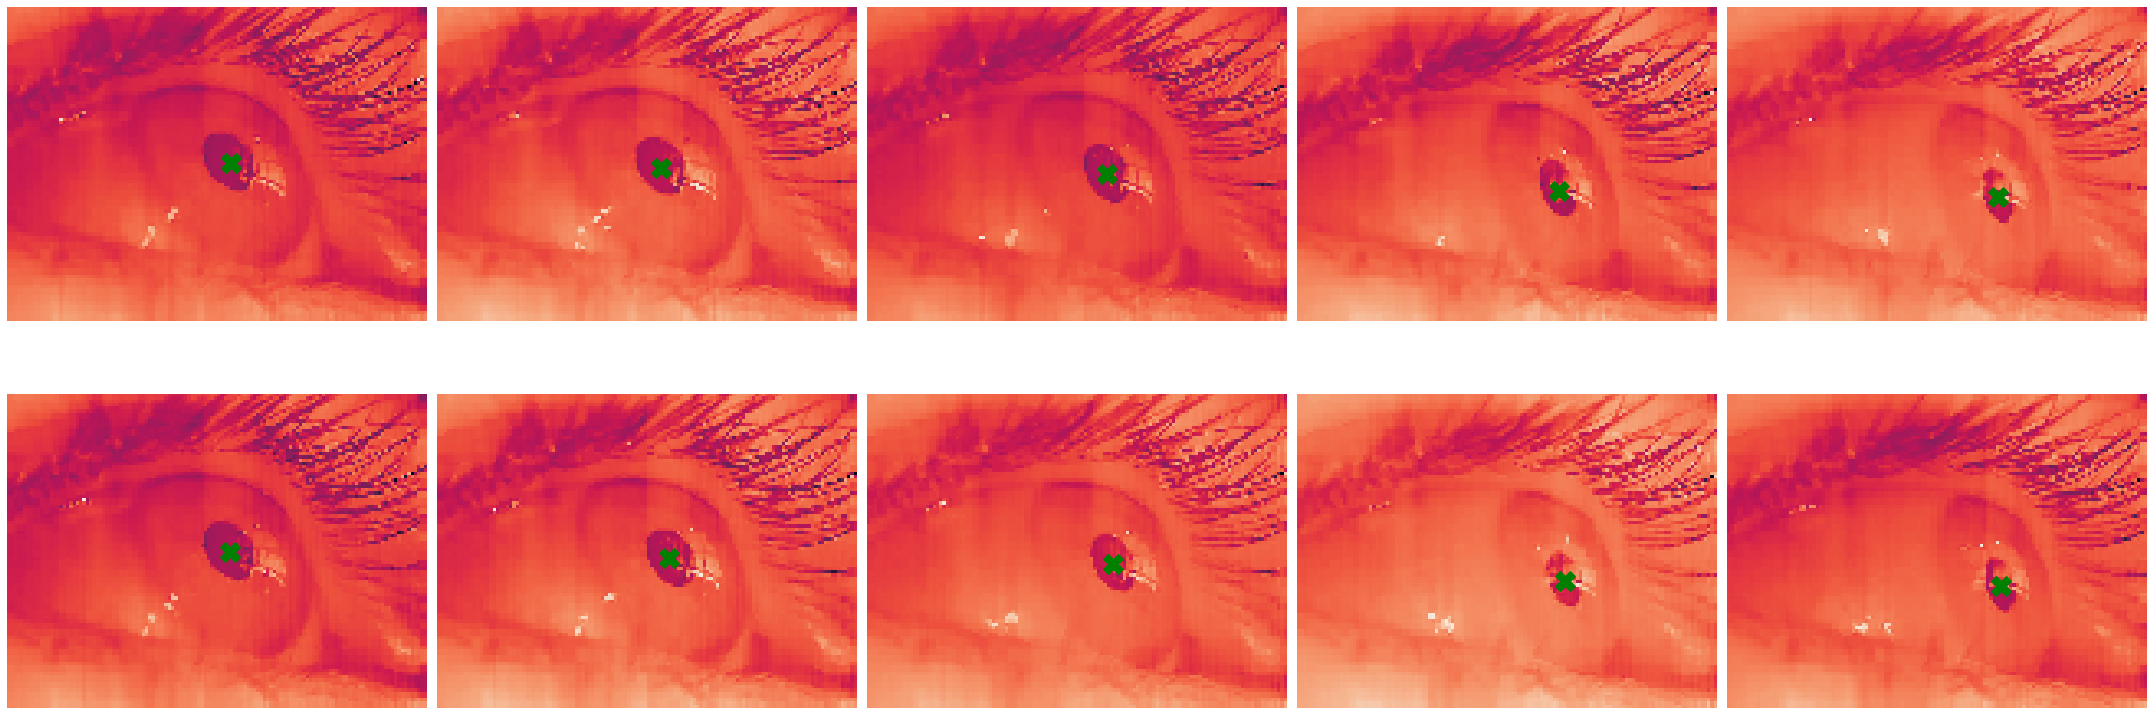

In [8]:
# plot converted sample image data along with keypoints data
utils.plot_image_keypoints(
    imgs=images[10:20],
    keypoints=keypoints[10:20],
    pivot='row')

[[ 1.22205015  1.25087912  1.2550737  ... -0.20565865 -0.69443655
  -1.37223334]
 [ 1.29175711  1.32233666  1.36554473 ... -0.06154748 -0.39278085
  -0.84371017]
 [ 1.32661059  1.42952297  1.36554473 ... -0.06154748 -0.31736693
  -0.44731779]
 ...
 [ 1.22205015  1.14369281  1.18142634 ...  0.15461928  0.05970269
  -0.05092541]
 [ 1.32661059  1.28660789  1.21825002 ...  0.37078603  0.28594446
   0.34546697]
 [ 1.32661059  1.28660789  1.21825002 ...  0.73106396  0.43677231
   0.60972855]] (0, x                             66.8
y                             61.0
image_name    thumb_01_01_0001.jpg
Name: 0, dtype: object)
[[ 1.25884554  1.26304971  1.28464264 ... -0.17763514 -1.0517048
  -1.32964562]
 [ 1.25884554  1.26304971  1.28464264 ... -0.17763514 -1.0517048
  -1.32964562]
 [ 1.29384385  1.29830785  1.39524864 ... -0.17763514 -0.59640081
  -0.81128631]
 ...
 [ 1.18884891  1.19253341  1.17403663 ...  0.27452703  0.08655519
  -0.03374735]
 [ 1.25884554  1.26304971  1.2109053  ...  0.597

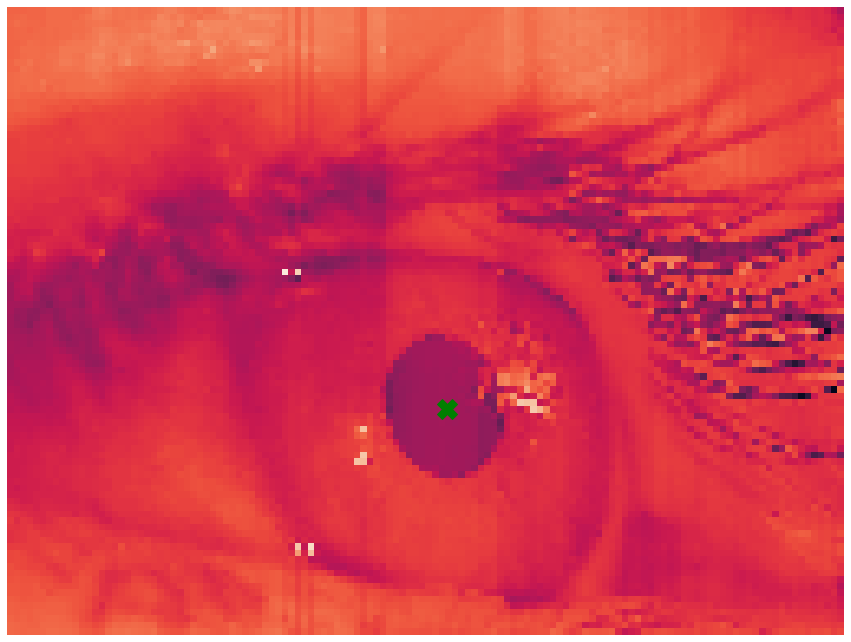

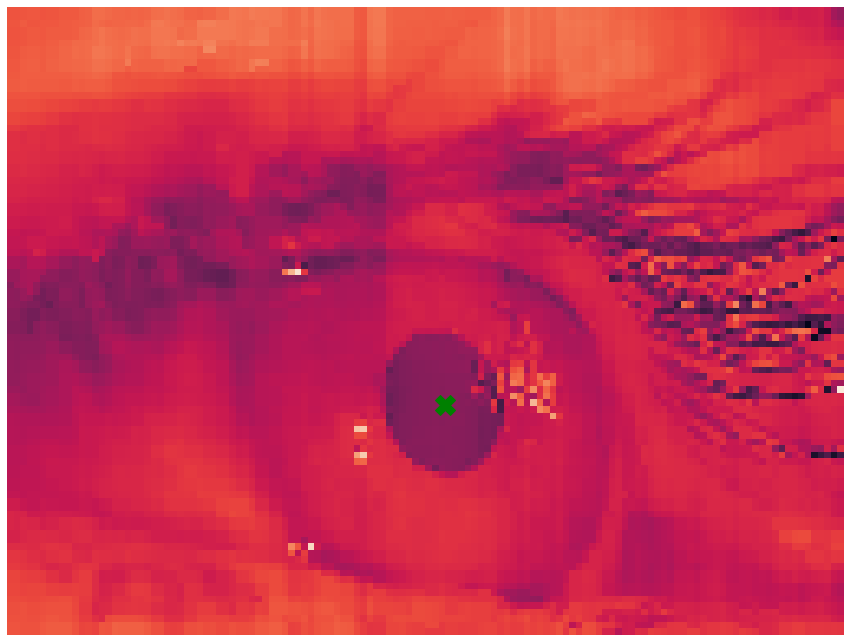

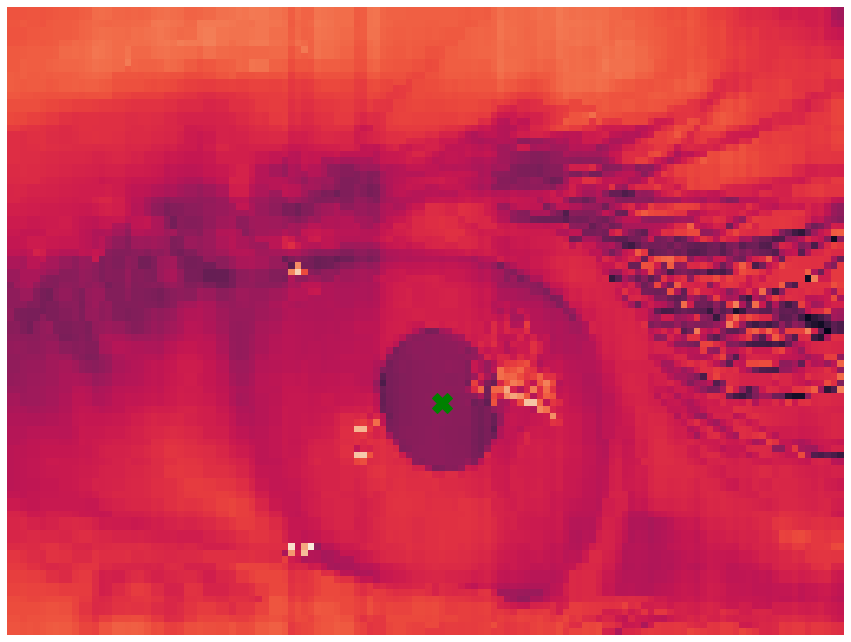

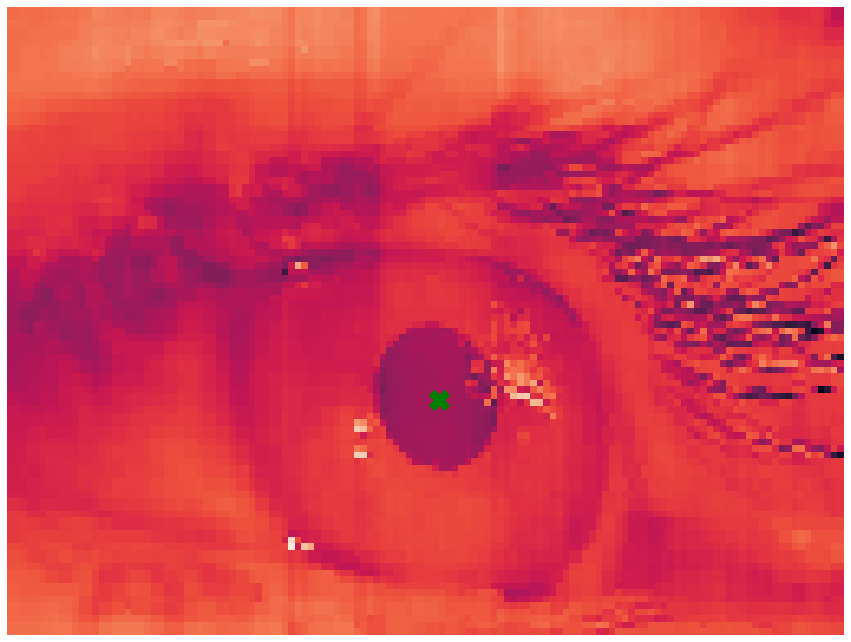

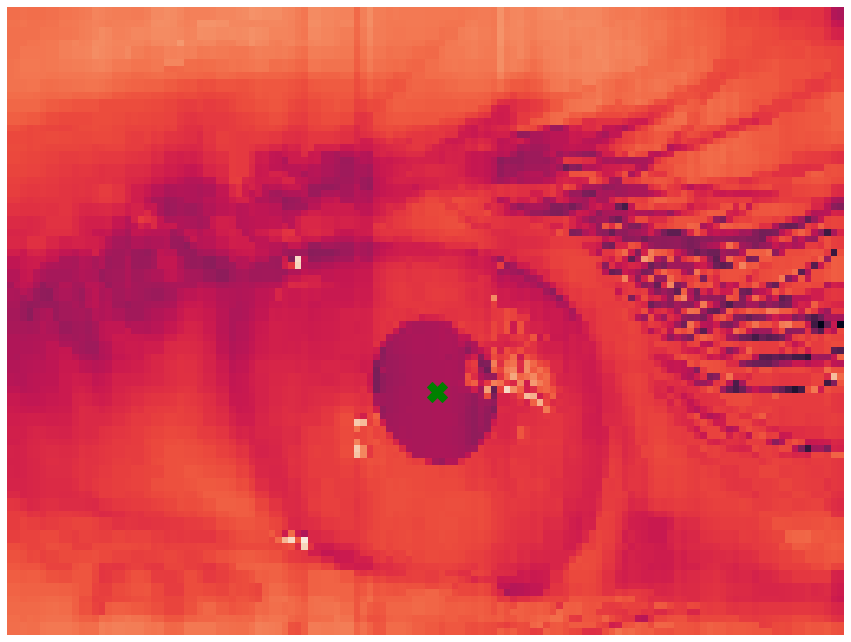

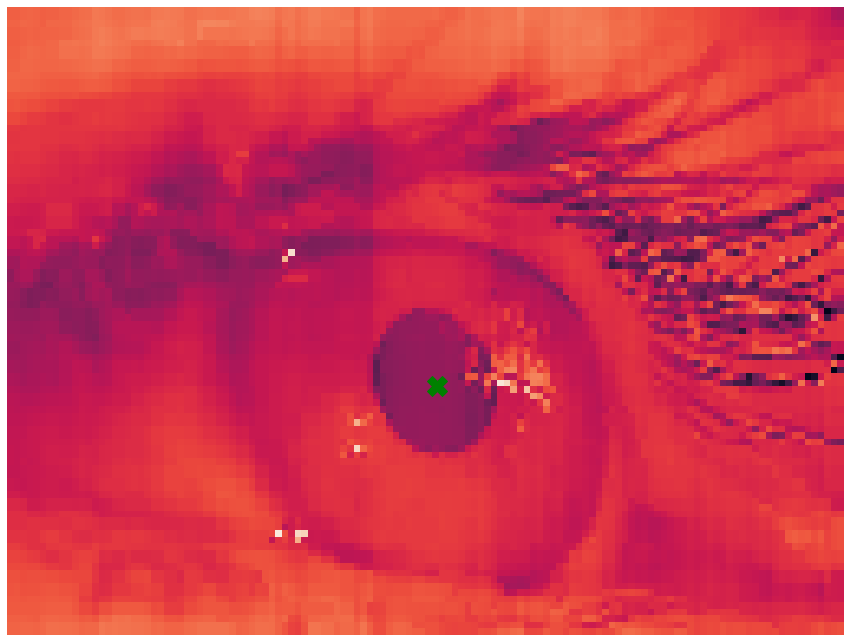

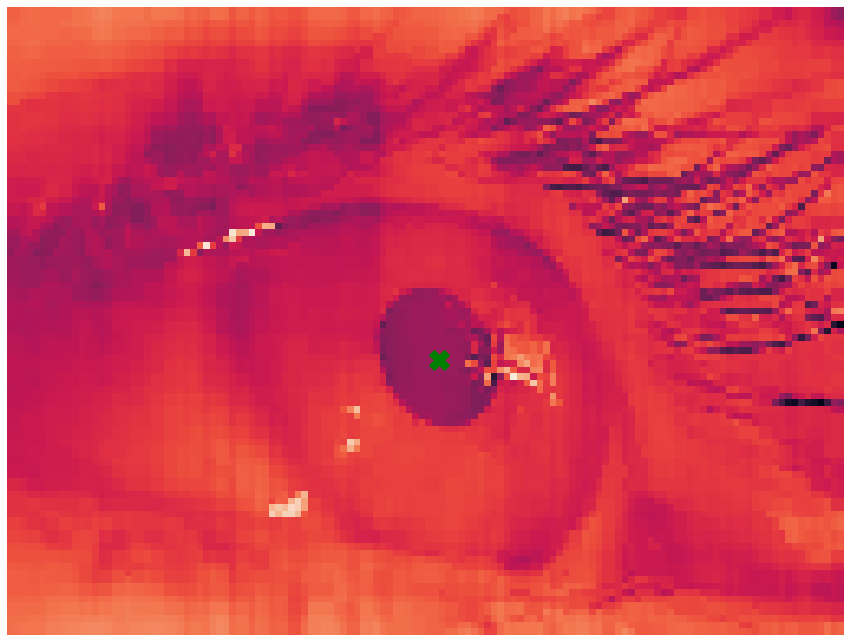

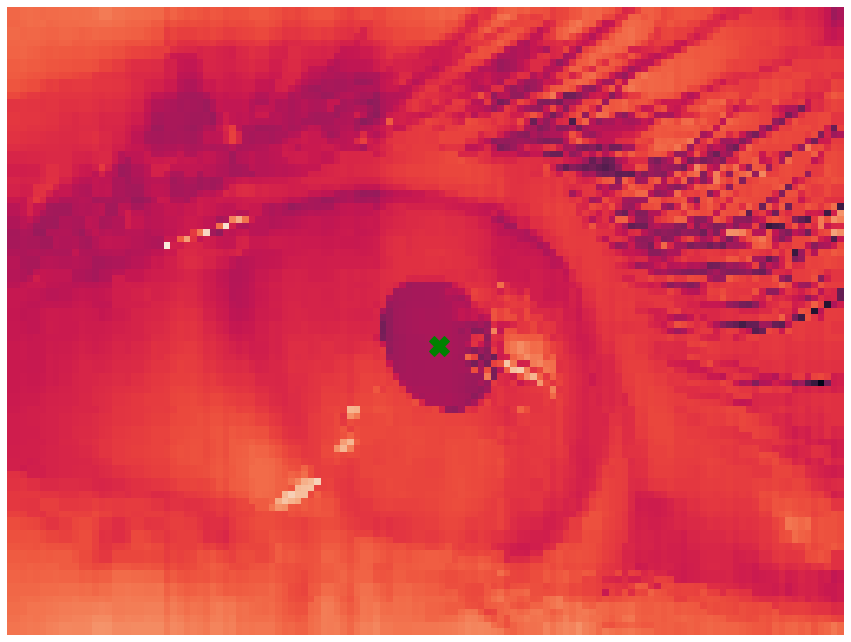

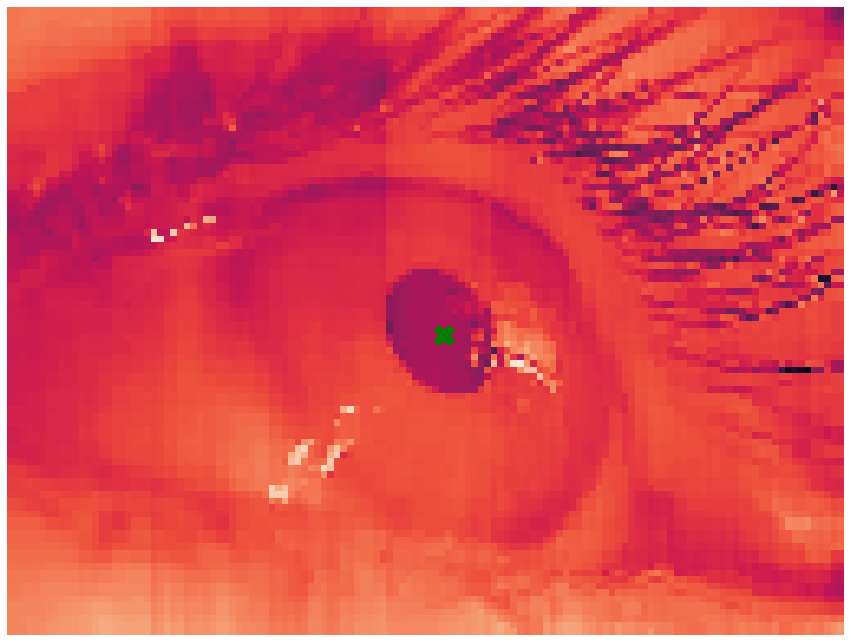

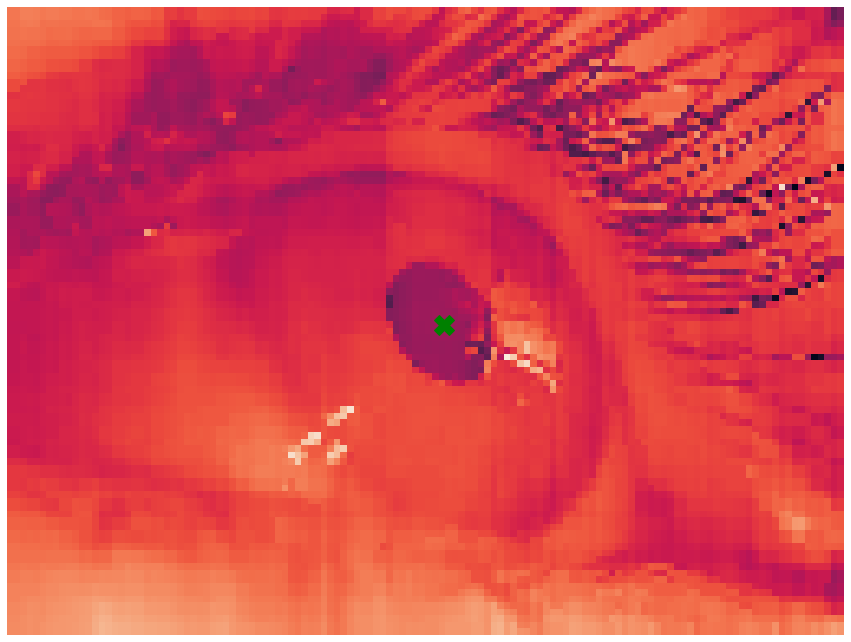

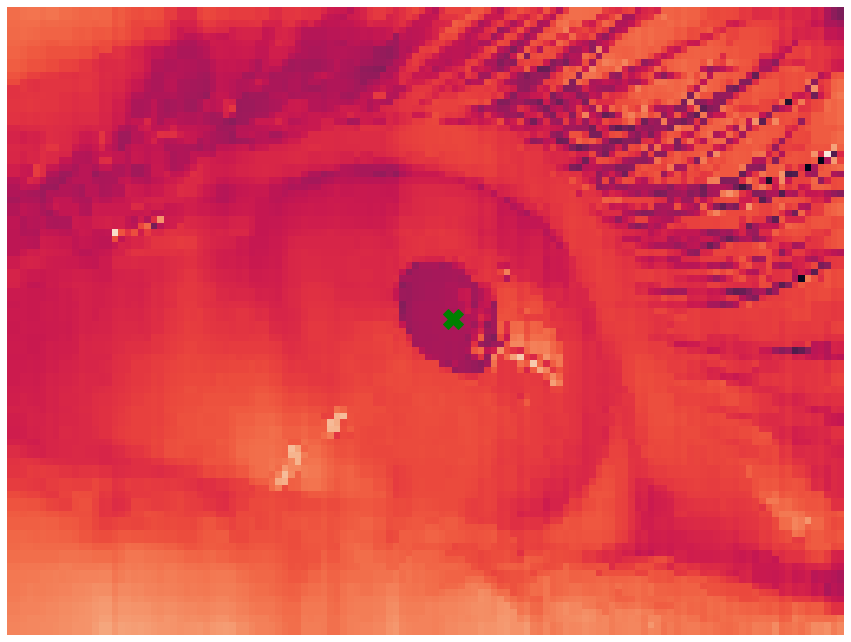

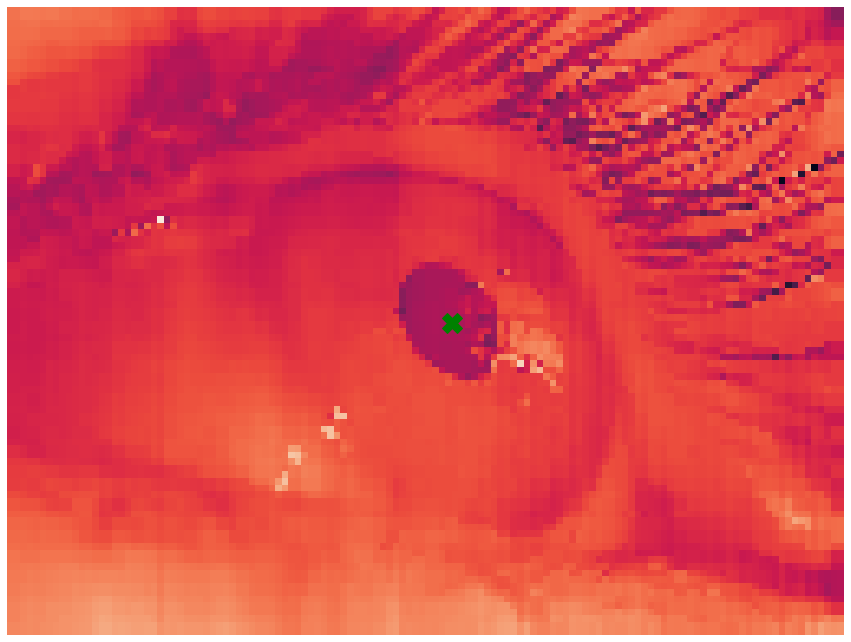

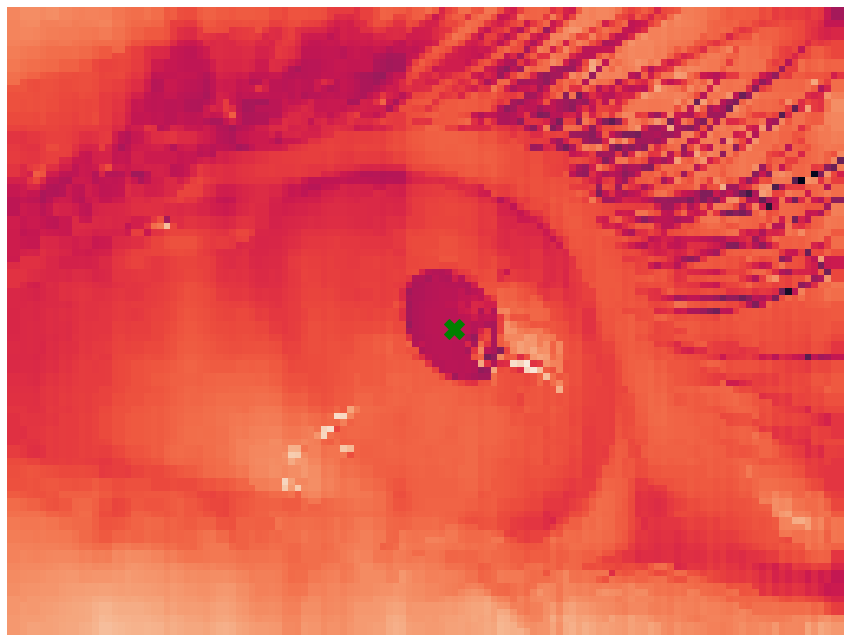

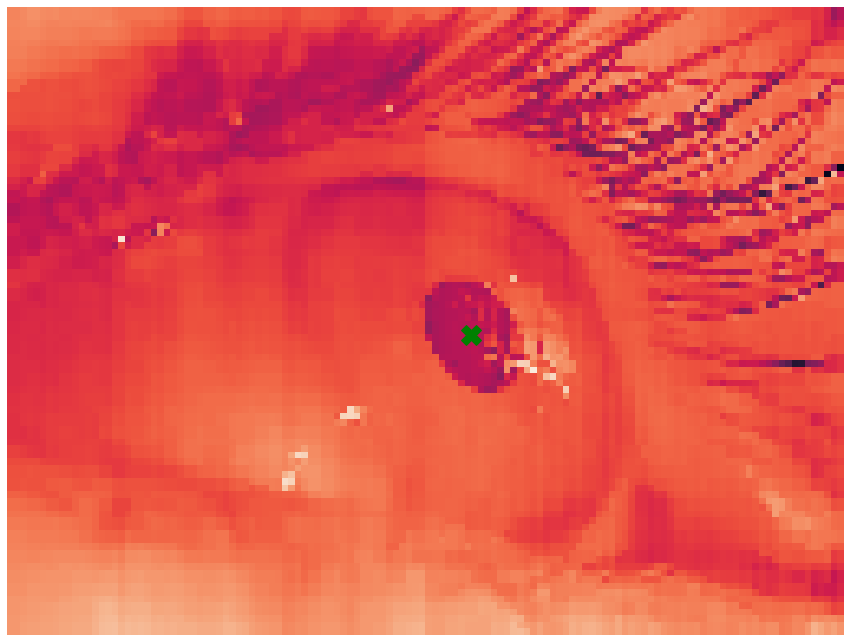

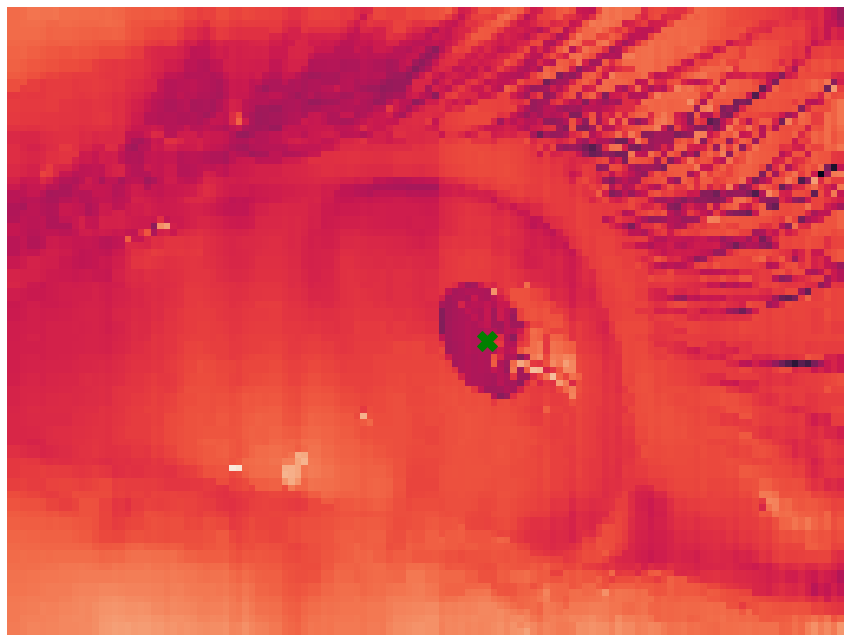

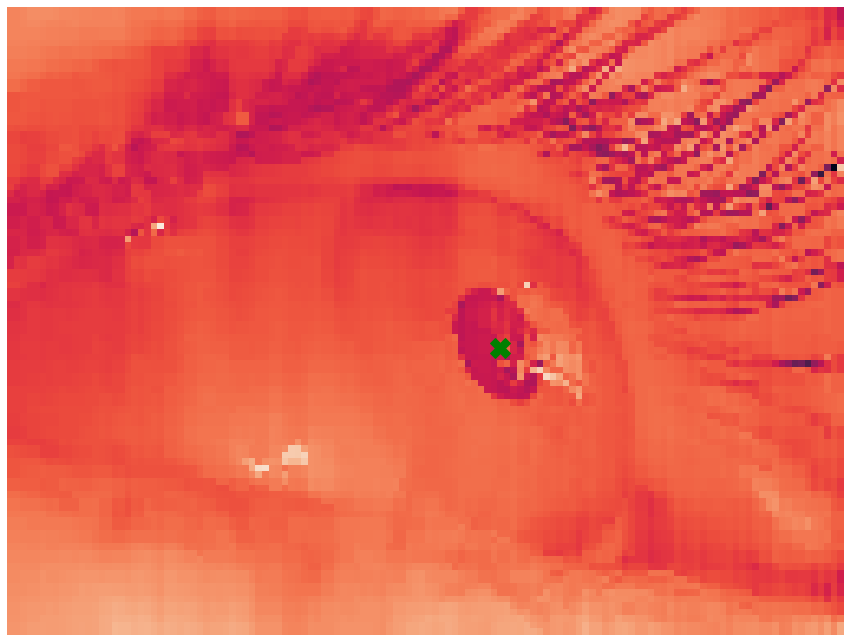

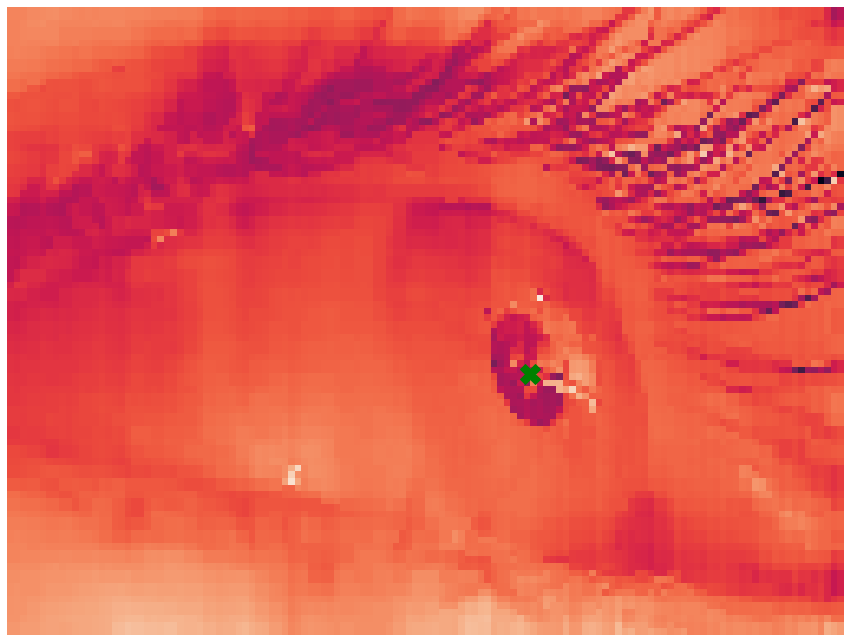

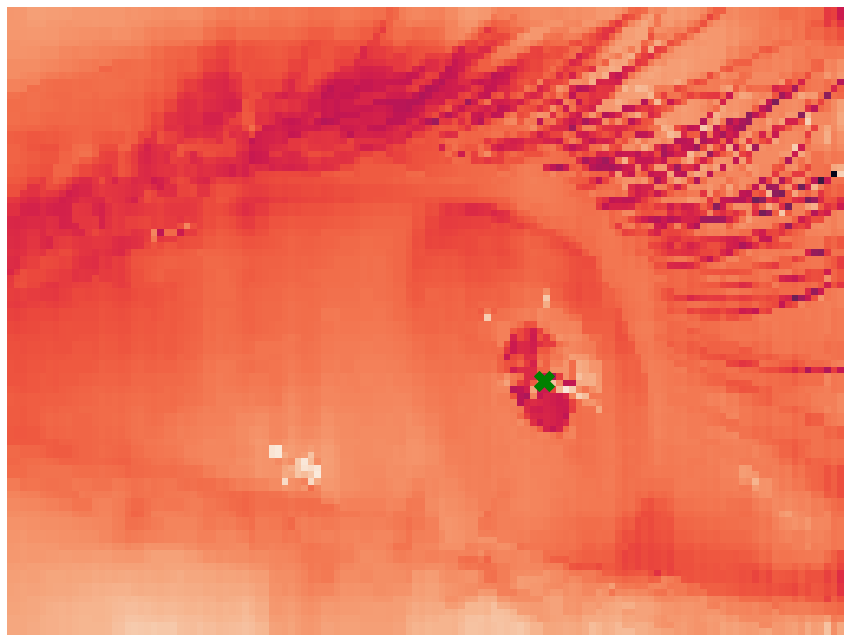

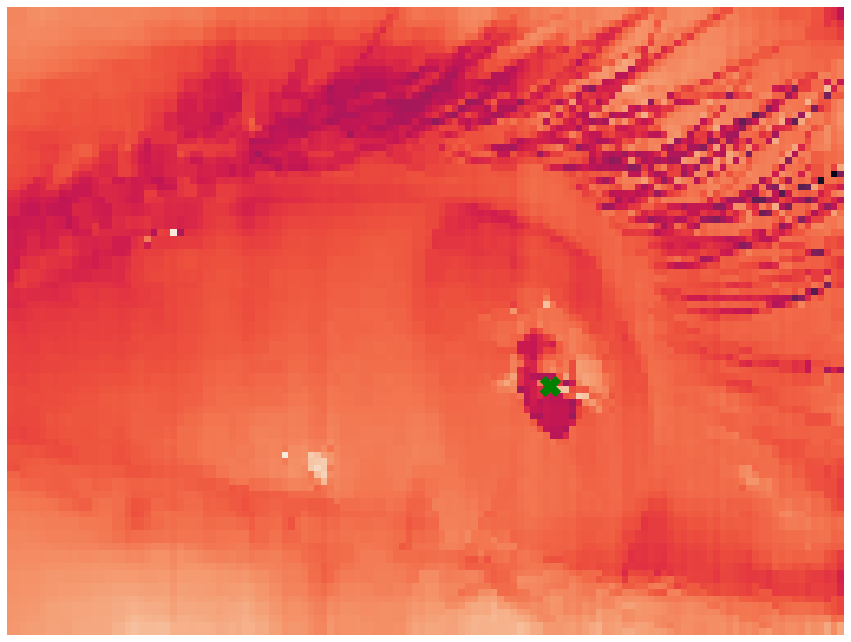

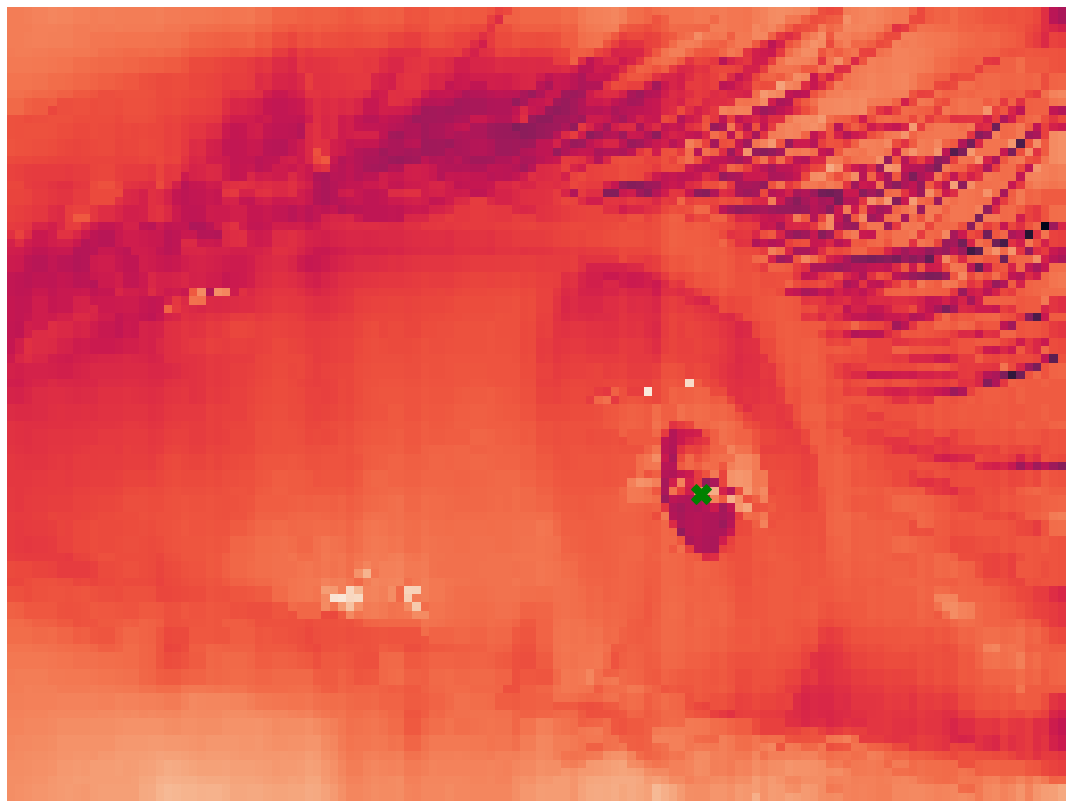

In [9]:
utils.show_image_keypoint(
    imgs=images,
    actual=keypoints,
    pred=None,
    window=(0,20),
    save=True)

In [10]:
np.array(images).shape

(500, 96, 128)

## Train/Test Data Split

Split 80/20 train/test respectively.

In [11]:
Xtrain, Xtest, ytrain, ytest = dataset.get_data(save=True)

Getting images in <grayscale>...
Getting image locations...
Resizing images from (480, 640) to (128, 96).

Reading data from ../data/lpw/1/1.txt...
Reading data from ../data/lpw/1/4.txt...
Reading data from ../data/lpw/1/9.txt...
Reducing keypoint data from (5999)...
... to (500)

Getting image filenames...
... and add column of image filenames to keypoint DataFrame.
SUMMARY
         ++++++++++
         Xtrain:	400
         Xtest:	100
         ytrain:	400
         ytest:	100

Saved Xtrain dataframe to ../output/train_val/P1_Xtrain.parquet.
Saved Xtest dataframe to ../output/train_val/P1_Xtest.parquet.
Saved ytrain dataframe to ../output/train_val/P1_ytrain.parquet.
Saved ytest dataframe to ../output/train_val/P1_ytest.parquet.


## Fit to Model

Getting images in <grayscale>...
Getting image locations...
Resizing images from (480, 640) to (128, 96).

Reading data from ../data/lpw/1/1.txt...
Reading data from ../data/lpw/1/4.txt...
Reading data from ../data/lpw/1/9.txt...
Reducing keypoint data from (5999)...
... to (500)

Getting image filenames...
... and add column of image filenames to keypoint DataFrame.
SUMMARY
         ++++++++++
         Xtrain:	400
         Xtest:	100
         ytrain:	400
         ytest:	100

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 92, 124, 64)       1664      
                                                                 
 re_lu (ReLU)                (None, 92, 124, 64)       0         
                                          

2022-06-23 04:50:38.369004: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - ETA: 0s - loss: 1783.9810

2022-06-23 04:50:39.343968: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../output/model/baseline/assets
13/13 [==============================] - 1s 89ms/step - loss: 1783.9810 - val_loss: 571.1343
Epoch 2/500
13/13 [==============================] - 1s 73ms/step - loss: 381.1850 - val_loss: 288.6740
Epoch 3/500
13/13 [==============================] - 1s 72ms/step - loss: 281.5823 - val_loss: 203.6526
Epoch 4/500
13/13 [==============================] - 1s 45ms/step - loss: 238.7143 - val_loss: 204.2165
Epoch 5/500
13/13 [==============================] - 1s 47ms/step - loss: 237.9108 - val_loss: 205.3655
Epoch 6/500
13/13 [==============================] - 1s 48ms/step - loss: 238.1846 - val_loss: 209.7749
Epoch 7/500
13/13 [==============================] - 1s 79ms/step - loss: 245.8474 - val_loss: 203.5406
Epoch 8/500
13/13 [==============================] - 1s 46ms/step - loss: 237.7814 - val_loss: 212.0508
Epoch 9/500
13/13 [==============================] - 1s 44ms/step - loss: 240.8157 - val_loss: 229.7780
Epoch 10

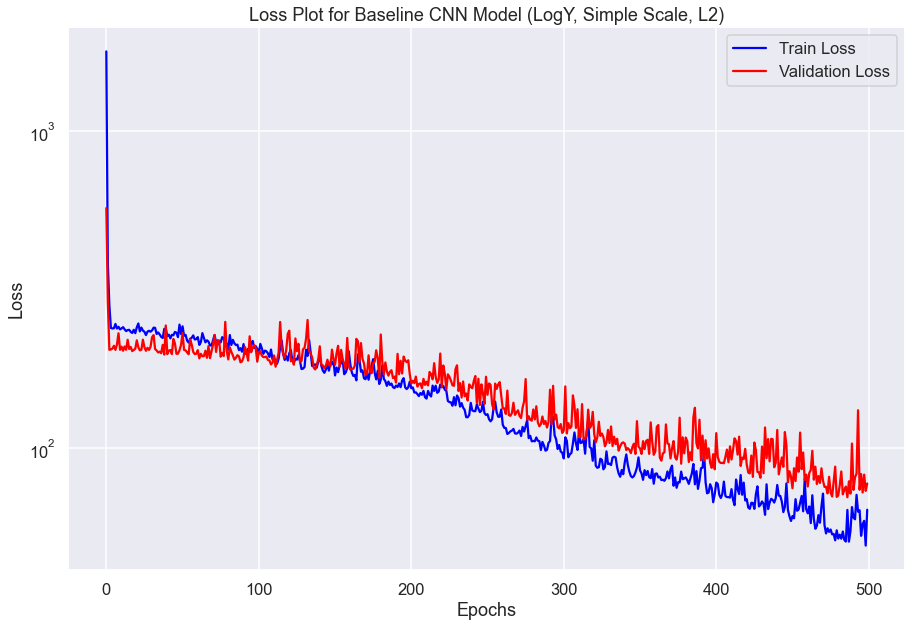

In [12]:
# save baseline_model at given checkpoints
model_checkpoint = ModelCheckpoint(
    filepath='../output/model/baseline',
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# load training and validation data
Xtrain, Xtest, ytrain, ytest = get_data(save=False)

Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)

# build and compile the baseline_model
baseline_model = baseline_model()
print(baseline_model.summary())

baseline_model.compile(
    optimizer=Adam(learning_rate=LR),
    loss=MeanSquaredError())

# train baseline_model
history = baseline_model.fit(
    Xtrain, ytrain,
    validation_data=(Xtest, ytest),
    epochs=EPOCHS,
    callbacks=[model_checkpoint],
    workers=4, 
    use_multiprocessing=True)

# plot and save history
utils.save_loss_plots(history, 'Loss Plot for Baseline CNN Model (LogY, Simple Scale, L2)', 'baseline_loss_logyplot_l2')

Getting images in <grayscale>...
Getting image locations...
Resizing images from (480, 640) to (128, 96).

Reading data from ../data/lpw/1/1.txt...
Reading data from ../data/lpw/1/4.txt...
Reading data from ../data/lpw/1/9.txt...
Reducing keypoint data from (5999)...
... to (500)

Getting image filenames...
... and add column of image filenames to keypoint DataFrame.
SUMMARY
         ++++++++++
         Xtrain:	400
         Xtest:	100
         ytrain:	400
         ytest:	100

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 128, 1)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 124, 32)       832       
                                                                 
 re_lu_2 (ReLU)              (None, 92, 124, 32)       0         
                                        

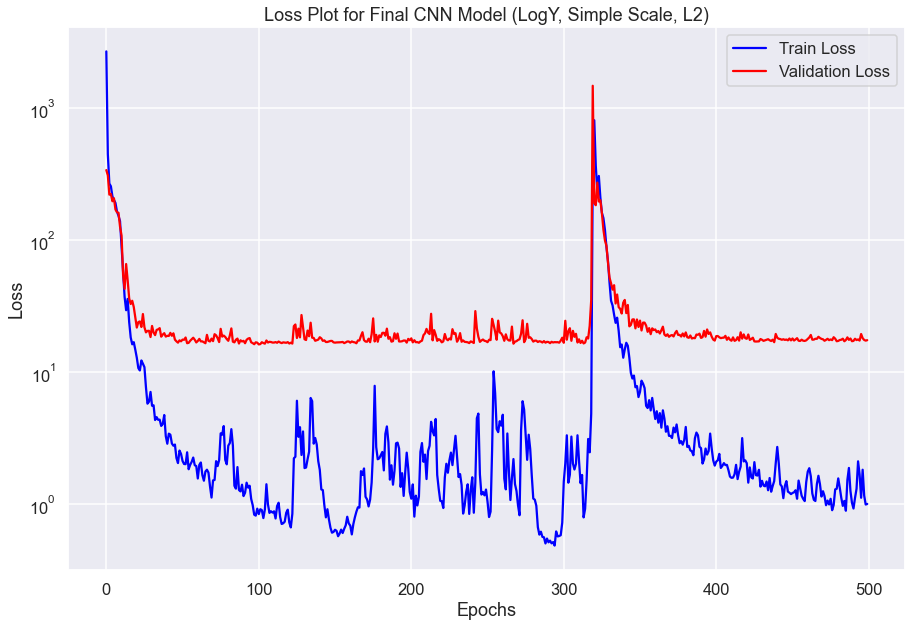

In [13]:
# save final_model at given checkpoints
model_checkpoint = ModelCheckpoint(
    filepath='../output/model/final',
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# load training and validation data
Xtrain, Xtest, ytrain, ytest = get_data(save=False)

Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)

# build and compile the final_model
final_model = final_model()
print(final_model.summary())

final_model.compile(
    optimizer=Adam(learning_rate=LR),
    loss=MeanSquaredError())

# train final_model
final_history = final_model.fit(
    Xtrain, ytrain,
    validation_data=(Xtest, ytest),
    epochs=EPOCHS,
    callbacks=[model_checkpoint],
    workers=4, 
    use_multiprocessing=True)

# plot and save history
utils.save_loss_plots(final_history, 'Loss Plot for Final CNN Model (LogY, Simple Scale, L2)', 'final_loss_logyplot_l2')

## Evaluation

In [14]:
baseline_score = baseline_model.evaluate(Xtest, ytest, verbose = 0)
final_score = final_model.evaluate(Xtest, ytest, verbose = 0) 

print('Baseline loss:', baseline_score)
print('Final loss:', final_score)

Baseline loss: 63.236087799072266
Final loss: 17.45923614501953


## Predictions

In [16]:
# calculate predictions
baseline_pred = baseline_model.predict(Xtest)
final_pred = final_model.predict(Xtest)

print(baseline_pred.shape)
print(baseline_pred)

print(final_pred.shape)
print(final_pred)

print(ytest)

# calculate 
baseline_pred_max = np.argmax(baseline_pred)
final_pred_max = np.argmax(final_pred)
keypoint = np.argmax(ytest)

print(baseline_pred_max) 
print(final_pred_max)

print(keypoint)

(100, 2)
[[ 66.27525   69.993515]
 [ 46.428707  60.853157]
 [ 40.501076  51.814148]
 [ 66.966194  60.542187]
 [ 69.114914  54.87064 ]
 [ 47.434837  57.581535]
 [ 49.145885  65.25261 ]
 [ 77.536545  57.73086 ]
 [ 53.972775  55.74657 ]
 [ 66.80189   61.16501 ]
 [ 51.48842   70.78733 ]
 [ 40.92928   53.15876 ]
 [ 61.75415   53.947247]
 [ 74.533165  65.502525]
 [ 63.70458   66.29245 ]
 [ 48.04742   57.71547 ]
 [ 40.771725  48.569542]
 [ 71.51445   66.15594 ]
 [ 78.73412   45.761574]
 [ 51.681686  65.514084]
 [ 37.257946  55.133545]
 [100.88127   60.737267]
 [ 64.36081   67.780685]
 [ 60.01626   52.445797]
 [ 51.095947  64.24778 ]
 [ 86.72926   57.409145]
 [ 63.159702  68.54515 ]
 [ 78.26181   60.322197]
 [ 91.1976    39.090122]
 [ 71.60353   54.856815]
 [ 47.866493  52.98682 ]
 [ 56.635956  66.90126 ]
 [ 61.880707  54.332058]
 [ 54.982822  55.643253]
 [102.62163   61.917988]
 [ 45.507946  60.951046]
 [ 55.86281   51.888416]
 [ 65.35419   59.472187]
 [ 74.94344   55.930782]
 [ 92.1017    46

In [ ]:
### Visualize Keypoint Predictions Against Actual

#
utils.show_image_keypoint(
    imgs=images,
    actual=ytest,
    pred=None,
    window=(0,20),
    save=True)